### Setup Environmnet

In [324]:
# # conda environment name and path is hardcoded - please update accordingly
# !conda env create -f environment.yml
# !conda activate sdv
# ! pip install -r installed_packages.txt

### Imports

In [325]:
import pandas as pd
import torch
import numpy as np
import os
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from sklearn.preprocessing import MinMaxScaler
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import networkx as nx
import random
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
import matplotlib.pyplot as plt

import pubchempy as pcp
import requests

from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

import xml.etree.ElementTree as ET
import pickle

import torchtext.vocab as vocab

### Seed all randomness

In [326]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage example:
seed_everything(42)  # Set the seed to 42

### Download Benchmark Dataset
downloaded from - https://github.com/yuliyi/idse-HE/tree/main/data

In [327]:
os.makedirs("../raw_data/idse-data", exist_ok=True)

In [328]:
# ! sudo apt-get install jq -y


In [329]:
# !curl -s -H "Accept: application/vnd.github.v3+json" https://api.github.com/repos/yuliyi/idse-HE/contents/data | jq -r '.[].download_url' | while read url; do wget -P ../raw_data/idse-data "$url"; done


### Download pre-trained models

In [330]:
os.makedirs("../downloaded_models/mol2vec", exist_ok=True)

In [331]:
## https://github.com/samoturk/mol2vec/tree/master/examples/models/model_300dim.pkl
## Fetch the download URL for the specific file and download it
# !curl -s -H "Accept: application/vnd.github.v3+json" \
#     https://api.github.com/repos/samoturk/mol2vec/contents/examples/models/model_300dim.pkl | \
#     jq -r '.download_url' | \
#     xargs -n 1 wget -P ../downloaded_models/mol2vec

### Read Benchmark Data

In [332]:
idse_data_path = "../raw_data/idse-data/"
se_name_and_drug_name_path = idse_data_path + "side-effect-and-drug_name.tsv"
drugs_smiles_fnm = "drugs.smiles"
drugs_uniq_name = "drugs.txt"

In [333]:
idse_association_df = pd.read_csv(se_name_and_drug_name_path, sep="\t")
idse_association_df = idse_association_df.drop(columns=idse_association_df.columns[0])

In [334]:
idse_association_df.head()

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
0,DB04441,2-Fluoroadenosine,C0000737,Abdominal pain
1,DB04441,2-Fluoroadenosine,C1168174,Absolute neutrophil count decreased
2,DB04441,2-Fluoroadenosine,C1096116,Acquired haemophilia
3,DB04441,2-Fluoroadenosine,C0948089,Acute coronary syndrome
4,DB04441,2-Fluoroadenosine,C0085669,Acute leukaemia


In [335]:
### merge drugname and drug smile information from drugs.txt and drugs.smiles 
### drugs.txt contains drugbank_id\tdrugname
### and drugs.smiles contains the drug smiles 

In [336]:
with open (f'{idse_data_path}{drugs_smiles_fnm}') as fp:
    drug_smiles = fp.read().split("\n")

with open(f'{idse_data_path}{drugs_uniq_name}') as fp:
    drugs_uniq_li = fp.read().split("\n")

In [337]:
drugs_uniq_li = [val.split("\t") for val in drugs_uniq_li] ## contains drugbank_id,drug_name

In [338]:
drugs_uniq_df = pd.DataFrame(columns=['drugbank_id', 'drug_name', 'drug_smiles'])
drugs_uniq_df['drugbank_id'], drugs_uniq_df['drug_name'] = zip(*drugs_uniq_li)
drugs_uniq_df['drug_smiles'] = drug_smiles

In [339]:
drugs_uniq_df = drugs_uniq_df[~drugs_uniq_df['drug_smiles'].str.contains('DB')]

In [340]:
drugs_uniq_df.head()

,drugbank_id,drug_name,drug_smiles
0,DB04441,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...
1,DB04789,5-methyltetrahydrofolate,CN1C(CNC2=CC=C(C=C2)C(=O)N[C@@H](CCC(O)=O)C(O)...
3,DB01048,Abacavir,NC1=NC2=C(N=CN2[C@@H]2C[C@H](CO)C=C2)C(NC2CC2)=N1
4,DB05812,Abiraterone,[H][C@@]12CC=C(C3=CC=CN=C3)[C@@]1(C)CC[C@@]1([...
5,DB00659,Acamprosate,CC(=O)NCCCS(O)(=O)=O


In [341]:
drugs_uniq_df.shape

(1007, 3)

In [342]:
idse_association_df['drugbank_id'].nunique(), idse_association_df['umls_cui_from_meddra'].nunique()

(1020, 5599)

In [343]:
idse_association_df = pd.merge(idse_association_df, drugs_uniq_df, on='drugbank_id', how='inner')

In [344]:
idse_association_df.head()

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name,drug_name,drug_smiles
0,DB04441,2-Fluoroadenosine,C0000737,Abdominal pain,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...
1,DB04441,2-Fluoroadenosine,C1168174,Absolute neutrophil count decreased,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...
2,DB04441,2-Fluoroadenosine,C1096116,Acquired haemophilia,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...
3,DB04441,2-Fluoroadenosine,C0948089,Acute coronary syndrome,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...
4,DB04441,2-Fluoroadenosine,C0085669,Acute leukaemia,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...


In [345]:
idse_association_df.shape

(132063, 6)

In [346]:
idse_association_df['drugbank_id'].nunique(), idse_association_df['umls_cui_from_meddra'].nunique()

(1007, 5587)

### Preprocess data

#### Create Drugbank ID to Smiles Mapping

In [347]:
drug_to_smile_dict = dict(drugs_uniq_df[['drugbank_id', 'drug_smiles']].values)

In [348]:
drug_to_smile_dict['DB00675']

'CC\\\\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=CC=CC=C1'

#### Drugbank id to Molgraph

In [349]:
drug_id_mol_graph_dict = {}
incorrect_smiles = []
for db_id in drugs_uniq_df['drugbank_id'].values:
    try:
        mol = Chem.MolFromSmiles(drug_to_smile_dict[db_id])
        if mol is None:
            incorrect_smiles.append((db_id, drug_to_smile_dict[db_id]))
            continue
        drug_id_mol_graph_dict[db_id] = mol
    except Exception as e:
        print(e)
        incorrect_smiles.append((db_id, drug_to_smile_dict[db_id]))

RDKit ERROR: [18:09:17] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:09:17] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [18:09:17] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:09:17] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [18:09:17] Explicit valence for atom # 2 O, 3, is greater than permitted
[18:09:17] Explicit valence for atom # 2 O, 3, is greater than permitted


In [350]:
len(drug_id_mol_graph_dict.keys()), len(incorrect_smiles)

(1004, 3)

In [351]:
incorrect_smiles

[('DB00958', '[H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N]([H])([H])[H]'),
 ('DB00515', '[H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H]'),
 ('DB00225',
  'O=C1[O-][Gd+3]234567[O]=C(C[N]2(CC[N]3(CC([O-]4)=O)CC[N]5(CC(=[O]6)NC)CC(=O)[O-]7)C1)NC')]

##### Patch in invlaid smiles

In [352]:
# Example list of DrugBank IDs
drugbank_ids, _ = zip(*incorrect_smiles)

# Function to get PubChem CID from DrugBank ID
def get_pubchem_cid(drugbank_id):
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drugbank_id}/cids/TXT'
    response = requests.get(url)
    if response.status_code == 200:
        cids = response.text.strip().split('\n')
        if cids:
            return cids[0]  # Return the first CID
    return None

# Dictionary to store DrugBank IDs and their SMILES strings
drug_smiles_dict = {}

for drugbank_id in drugbank_ids:
    # Get PubChem CID
    cid = get_pubchem_cid(drugbank_id)
    if cid:
        try:
            # Fetch the compound from PubChem
            compound = pcp.Compound.from_cid(cid)
            # Get the canonical SMILES string
            smiles = compound.canonical_smiles
            if smiles:
                drug_smiles_dict[drugbank_id] = smiles
                print(f"Fetched SMILES for DrugBank ID: {drugbank_id} -> {smiles}")
            else:
                print(f"No SMILES found for DrugBank ID: {drugbank_id}")
        except Exception as e:
            print(f"Error fetching SMILES for DrugBank ID: {drugbank_id}")
            print(e)
    else:
        print(f"PubChem CID not found for DrugBank ID: {drugbank_id}")

# Display the fetched SMILES strings
print("Fetched SMILES strings:")
for db_id, smiles in drug_smiles_dict.items():
    print(f"{db_id}: {smiles}")


Fetched SMILES for DrugBank ID: DB00958 -> C1CC(C1)(C(=O)O)C(=O)O.N.N.[Pt+2]
Fetched SMILES for DrugBank ID: DB00515 -> N.N.Cl[Pt+2]Cl
Fetched SMILES for DrugBank ID: DB00225 -> CNC(=O)CN(CCN(CCN(CC(=O)NC)CC(=O)[O-])CC(=O)[O-])CC(=O)[O-].[Gd+3]
Fetched SMILES strings:
DB00958: C1CC(C1)(C(=O)O)C(=O)O.N.N.[Pt+2]
DB00515: N.N.Cl[Pt+2]Cl
DB00225: CNC(=O)CN(CCN(CCN(CC(=O)NC)CC(=O)[O-])CC(=O)[O-])CC(=O)[O-].[Gd+3]


In [353]:
for db_id, smiles in drug_smiles_dict.items():
    drug_id_mol_graph_dict[db_id] = Chem.MolFromSmiles(smiles)

In [354]:
len(drug_id_mol_graph_dict.keys())

1007

#### Create Transformation mappings for drug and side effects

In [355]:
idse_association_df['drugbank_id'].nunique(), idse_association_df['umls_cui_from_meddra'].nunique(), idse_association_df.shape

(1007, 5587, (132063, 6))

In [356]:
all_drug_id = idse_association_df['drugbank_id'].unique()
all_drug_id.sort()
all_se_id = idse_association_df['umls_cui_from_meddra'].unique()
all_se_id.sort()
len(all_drug_id), len(all_se_id)

(1007, 5587)

In [357]:
# drug to id mapping
DB_TO_ID_DICT = {id: idx for idx, id in enumerate(all_drug_id)}
ID_TO_DB_DICT = {v: k for k, v in DB_TO_ID_DICT.items()}

In [358]:
# side effect to id mapping
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(all_se_id)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [359]:
drug_id_mol_graph_tup = [(id, drug_id_mol_graph_dict[id]) for id in all_drug_id]

In [360]:
for dict_, fnm in zip([DB_TO_ID_DICT, ID_TO_DB_DICT, MEDRAID_TO_ID_DICT, ID_TO_MEDRAID_DICT, drug_id_mol_graph_tup ],
                 ['db_to_id.pt', 'id_to_db.pt', 'uml_to_id.pt', 'id_to_uml.pt', 'drug_to_mol.pt']):
    full_path = f"../prep_data/hetero_graph/{fnm}"
    os.makedirs(os.path.dirname(full_path), exist_ok=True)
    torch.save(dict_, full_path)
    

In [361]:
def edge_name_to_id(edge_list, map_dict):
    return [(map_dict[edge[0]], map_dict[edge[1]]) for edge in edge_list]

#### SE ID to Name

In [362]:
idse_association_df.head(1)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name,drug_name,drug_smiles
0,DB04441,2-Fluoroadenosine,C0000737,Abdominal pain,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...


In [363]:
se_uml_to_se_name_dict = dict(idse_association_df[['umls_cui_from_meddra', 'side_effect_name']].values)

In [364]:
se_uml_to_se_name_dict = {k:v.lower() for k, v in se_uml_to_se_name_dict.items()}
se_name_to_se_uml_dict = {v:k for k, v in se_uml_to_se_name_dict.items()}

In [365]:
se_uml_to_se_name_dict['C0000737']

'abdominal pain'

In [366]:
se_name_to_se_uml_dict['abdominal pain']

'C0000737'

### Known Association

In [367]:
# create edge index using known drug-side effect association
edge_index = []
for idx, row in idse_association_df.iterrows():
    edge_index.append([DB_TO_ID_DICT[row['drugbank_id']], MEDRAID_TO_ID_DICT[row['umls_cui_from_meddra']]])

edge_index = torch.tensor(edge_index).T

print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 132063])
edge_index tensor([[ 861,  861,  861,  ...,  963,  963,  963],
        [   4, 5033, 4851,  ..., 1547, 1594, 1609]])


### Feature Acquisition

#### Utils

In [368]:
##### Analyze and get Similarity edges
def get_similarity_pairs_names(df, similarity_scores, upper_triangle_indices, threshold_similarity, type):
    # Extract drug IDs for the corresponding indices
    name_ids = df.index

    # Initialize lists to store results
    name_pairs = []
    name_pairs_attr = []

    # Filter and collect pairs above the threshold
    for index, sim in enumerate(similarity_scores):
        if sim > threshold_similarity:
            i, j = upper_triangle_indices[0][index], upper_triangle_indices[1][index]
            name_pairs.append([name_ids[i], name_ids[j]])
            name_pairs_attr.append(sim)

    # Convert results to DataFrame
    name_pair_sim_df = pd.DataFrame({
        f'{type.title()} Pair': name_pairs,
        'Similarity': name_pairs_attr
    })

    # Output the number of pairs and a sample of the pairs
    print(f'Number of {type} pairs with similarity above {threshold_similarity}: {len(name_pairs)}')
    print('Sample pairs:', name_pairs[:5])
    name_pair_sim_df.head()

    return name_pair_sim_df, name_pairs, name_pairs_attr

def get_sim_thresh_plot(similarity_scores_df, threshold_similarity, title, num_bins, x_ticks):
    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot histogram with dynamic bin size
    plt.hist(similarity_scores_df['Similarity'], bins=num_bins, edgecolor='black')

    # Set x-axis ticks to be in increments of 0.1
    plt.xticks(np.arange(*x_ticks))

    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.title(title)

    # Plot vertical line at the threshold
    plt.axvline(x=threshold_similarity, color='r', linestyle='--', label=f'Threshold = {threshold_similarity}')

    # Add legend
    plt.legend()
    return plt

def analyse_similarity_and_get_edge(df, name_to_id=None, compute_sim=None, threshold_similarity=0.3, 
                                    title='Distribution of Similarity Scores for SESemantic', 
                                    num_bins=20, x_ticks=(0, 1.1, 0.1), type='drug'):
    if compute_sim is not None:
        # Compute similarity scores using the provided function
        if compute_sim=='jaccard':
            sim_scores = 1 - pairwise_distances(df.values, metric='jaccard')
        if compute_sim=="cosine":
            sim_scores = cosine_similarity(df.values)
    else:
        sim_scores = df.values
    # Extract upper triangle of the similarity matrix, excluding the diagonal
    upper_triangle_indices = np.triu_indices_from(sim_scores, k=1)
    similarity_scores = sim_scores[upper_triangle_indices]

    # Create a DataFrame of the similarity scores
    similarity_scores_df = pd.DataFrame(similarity_scores, columns=['Similarity'])

    # Count pairs above the threshold
    count_above_threshold = (similarity_scores_df['Similarity'] > threshold_similarity).sum()
    total_pairs = similarity_scores_df.shape[0]

    print(f'Number of pairs with similarity above {threshold_similarity}: {count_above_threshold}/{total_pairs}')
    print(f'Percentage above threshold_similarity {threshold_similarity}: {count_above_threshold/total_pairs}')

    plt = get_sim_thresh_plot(similarity_scores_df, threshold_similarity, title, num_bins, x_ticks)
    name_pair_sim_df, name_pairs, name_pairs_attr = get_similarity_pairs_names(df, similarity_scores, upper_triangle_indices, threshold_similarity, type)
    if name_to_id is not None: name_pairs = edge_name_to_id(name_pairs, name_to_id)
    return plt, name_pair_sim_df, name_pairs, name_pairs_attr

#### Drug structure - Fingerprint

In [369]:
# use rdkit to convert smiles to fingerprint
def smiles2fp(chem_mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(chem_mol, 2, nBits=881)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [370]:
fingerprint_dict  = {id: smiles2fp(drug_id_mol_graph_dict[id]) for id in all_drug_id}

In [371]:
drug_id_fv_df = pd.DataFrame.from_dict(fingerprint_dict, orient='index').astype(bool)
drug_id_fv_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880
DB00014,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,F

##### Similarity using Jaccard Score

Number of pairs with similarity above 0.2: 15844/506521
Percentage above threshold_similarity 0.2: 0.0312800456447018
Number of drug pairs with similarity above 0.2: 15844
Sample pairs: [['DB00014', 'DB00035'], ['DB00014', 'DB00050'], ['DB00014', 'DB00104'], ['DB00014', 'DB00188'], ['DB00014', 'DB00224']]


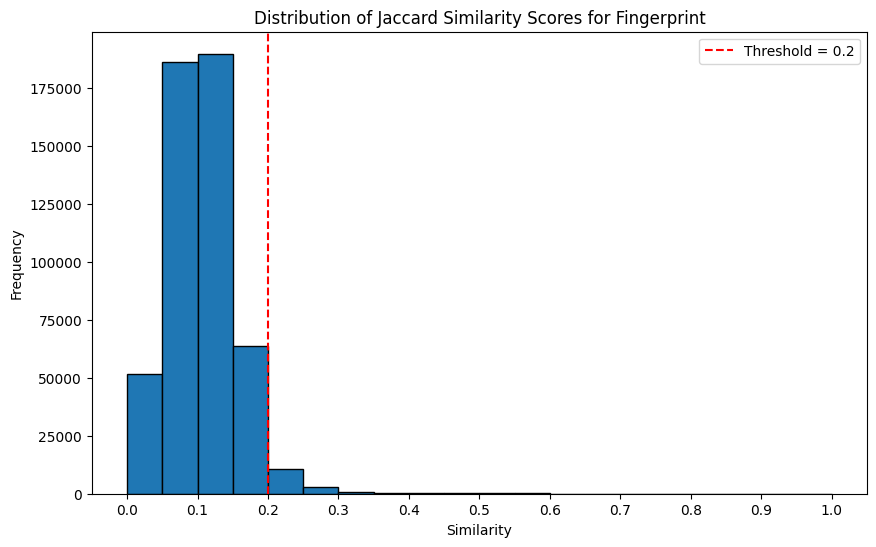

In [372]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(drug_id_fv_df, name_to_id=None, compute_sim='jaccard', threshold_similarity=0.2, title='Distribution of Jaccard Similarity Scores for Fingerprint', type='drug')

##### Drug SubStructure Edges

In [373]:
drug_struct_pairs_id = edge_name_to_id(name_pairs, DB_TO_ID_DICT)

In [374]:
drug_struct_pairs_id_edge_index = torch.tensor(drug_struct_pairs_id).T
drug_struct_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', drug_struct_pairs_id_edge_index.shape)
print('edge_index', drug_struct_pairs_id_edge_index[:5])
print('edge_attributes', drug_struct_pairs_id_edge_attr.shape)
print('edge_attributes', drug_struct_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 15844])
edge_index tensor([[   0,    0,    0,  ..., 1000, 1001, 1003],
        [   1,    2,    4,  ..., 1003, 1004, 1006]])
edge_attributes torch.Size([15844])
edge_attributes tensor([0.3355, 0.4267, 0.3333, 0.2424, 0.2115], dtype=torch.float64)


#### Drug Word - mol2vec

In [375]:
mol2vec_model = word2vec.Word2Vec.load('../downloaded_models/mol2vec/model_300dim.pkl')

In [376]:
drug_id_mol_graph_df = pd.DataFrame(drug_id_mol_graph_tup, columns=['drug_id', 'mol_graph'])

In [377]:
# use mol2vec to convert smiles to vec
drug_id_mol_graph_df['sentence'] = drug_id_mol_graph_df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol_graph'], 1)), axis=1) 
drug_id_mol_graph_df['mol2vec'] = [DfVec(x) for x in sentences2vec(drug_id_mol_graph_df['sentence'], mol2vec_model, unseen='UNK')]
mol2vec_rep_dict  = {row['drug_id']: row['mol2vec'].vec for idx, row in drug_id_mol_graph_df.iterrows() }
drug_id_mol_graph_df.head(1)

,drug_id,mol_graph,sentence,mol2vec
0,DB00014,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3537119515, 2245273601, 242354360...","(300,) dimensional vector"


In [378]:
drug_id_mol_graph_df = pd.DataFrame.from_dict(mol2vec_rep_dict, orient='index')
drug_id_mol_graph_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
DB00014,-4.754961,-10.429663,-7.996422,1.279,10.876369,-11.11908,-42.606743,-10.638518,38.510563,5.600776,-5.541176,12.603607,-8.373124,4.721805,-38.80965,0.854681,28.274664,-38.879128,-34.558567,31.648947,10.804585,28.908049,62.651314,17.287773,-17.505087,6.842953,-20.547663,-41.296604,8.170259,-18.359282,27.736025,-17.104425,-15.657434,-6.395205,-5.925633,13.698391,-5.502937,6.847603,24.273273,27.000477,6.480865,13.138721,-13.774258,-6.258449,-24.396008,19.485365,14.691991,54.9496,-27.654219,7.637133,9.489252,-25.650322,0.139462,-28.18774,-33.858273,-45.624317,-21.374472,16.327444,12.267965,13.8974,9.322758,-23.655632,-22.464878,22.747797,-51.132298,-2.370824,24.805935,7.877127,-30.128822,-3.09531,-4.893778,14.575936,15.052371,-36.619583,1.468378,25.017797,-40.463543,-0.218956,12.050858,0.704194,30.895391,-6.708903,3.740104,-57.152668,26.885086,-19.240383,-12.74862,-2.801934,3.493312,-12.977166,20.473257,16.672552,12.435864,23.935789,20.41057,-3.295291,31.031843,8.055426,33.367653,-7.684295,-10.26668,-27.067144,-36.274574,-27.553709,20.270407,-34.63932,-22.896017,16.536673,10.262356,-24.199192,-37.072071,25.398973,29.055456,-25.445021,3.36336,-18.149048,31.90658,19.902582,-2.669675,28.894135,-24.700897,7.853138,-6.010608,31.58741,2.195745,-36.409435,-34.694702,-1.605513,-19.285759,4.865229,-1.084233,-8.455152,17.721666,59.120193,-2.672402,34.715843,8.585008,-9.266812,27.893101,-8.467147,27.340704,-10.465919,-7.385633,-9.647074,25.671761,2.44578,14.637366,4.745203,9.472423,48.332039,1.079386,14.748192,23.80047,-25.588743,0.526035,13.008167,-20.502811,-3.476199,1.926056,-25.867573,9.244424,11.317245,-19.531881,17.794735,19.696854,-31.388252,12.644621,-6.370873,4.453772,22.575613,-27.434566,-21.828842,44.649948,-5.9303,10.253652,1.535209,25.41296,-13.130071,-18.278713,19.658169,-15.758171,35.767895,-0.629242,34.22855,10.617271,-18.186493,4.022352,0.893854,-22.529577,-20.152555,8.97603,-6.6412,-25.901318,4.457242,26.603155,14.060347,-2.316099,-45.021034,-9.84083,-15.134597,-2.360836,-4.424515,23.296936,-8.813356,5.869755,-15.131598,32.303082,37.706715,28.446321,-14.560642,46.978844,2.163737,38.038792,-16.00963,20.772953,5.389928,17.171217,15.237553,-25.278023,17.626675,15.792319,-26.018202,-8.40282,5.296094,12.746843,-18.19418,-0.602936,5.982893,27.290892,-33.39603,2.999893,-5.805064,-37.123283,-17.275055,-9.847339,-21.606216,-7.719473,0.969924,-10.964355,29.675402,21.666145,-28.978853,25.739546,-12.803493,-15.117129,15.492269,-57.070061,-26.437626,2.487059,8.627333,-65.833572,15.58671,12.454032,-17.492235,-32.972023,18.902876,12.175129,-32.891514,35.245884,-40.214947,-2.431331,8.712996,7.061657,23.623381,-2.394569,-32.480515,-23.175501,2.827142,21.47612,-28.86651,2.131786,19.814342,-12.546048,0.07743,-3.975087,-22.210964,-16.857395,-15.829368,-6.757376,11.813743,-20.907784,-15.605067,-44.81768,-18.700165,-6.062445,14.479069,5.577918,-7.321301,-19.840204,-11.

##### Similarity using Cosine Similarity

Number of pairs with similarity above 0.9: 83865/506521
Percentage above threshold_similarity 0.9: 0.16557062787130247
Number of drug pairs with similarity above 0.9: 83865
Sample pairs: [['DB00014', 'DB00035'], ['DB00014', 'DB00050'], ['DB00014', 'DB00104'], ['DB00014', 'DB00125'], ['DB00014', 'DB00130']]


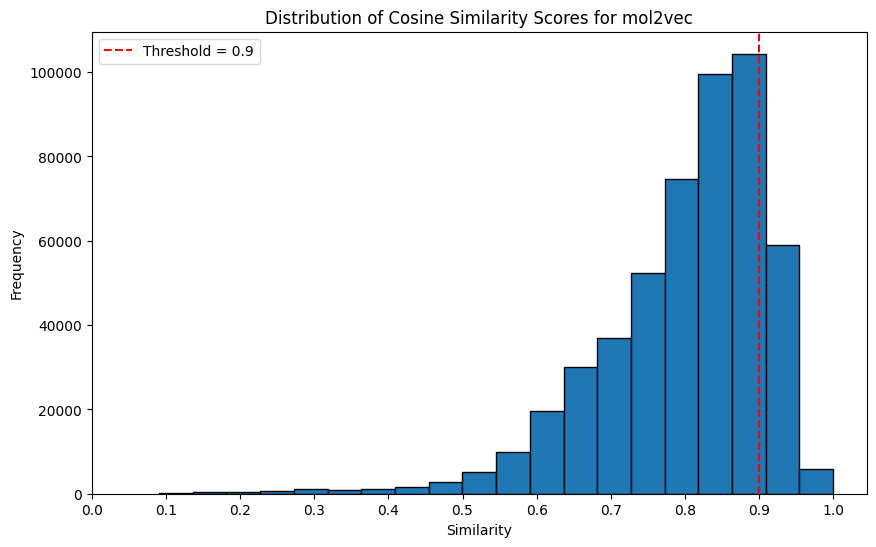

In [379]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(drug_id_mol_graph_df, name_to_id=None, compute_sim='cosine', threshold_similarity=0.9, title='Distribution of Cosine Similarity Scores for mol2vec', type='drug')

##### Drug Word Edges

In [380]:
drug_word_pairs_id = edge_name_to_id(name_pairs, DB_TO_ID_DICT)

In [381]:
drug_word_pairs_id_edge_index = torch.tensor(drug_word_pairs_id).T
drug_word_pairs_id_edge_attr = torch.tensor(name_pairs_attr) # .unsqueeze(1) #, dtype=torch.float64)

print('edge_index', drug_word_pairs_id_edge_index.shape)
print('edge_index', drug_word_pairs_id_edge_index[:5])
print('edge_attributes', drug_word_pairs_id_edge_attr.shape)
print('edge_attributes', drug_word_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 83865])
edge_index tensor([[   0,    0,    0,  ..., 1002, 1002, 1003],
        [   1,    2,    4,  ..., 1003, 1006, 1006]])
edge_attributes torch.Size([83865])
edge_attributes tensor([0.9509, 0.9936, 0.9372, 0.9176, 0.9336])


#### Drug Target - Drugbank

##### Load drugbank data

In [382]:
os.makedirs("../prep_data/drugbank", exist_ok=True)
drug_id_pubchem_mapping_dump_loc = "../prep_data/drugbank/drug_id_pubchem_mapping.pkl"
drug_target_dump_loc = '../prep_data/drugbank/drug_targets.pkl'

In [383]:
# check os file exists
prep_done = os.path.exists(drug_id_pubchem_mapping_dump_loc)
prep_target = os.path.exists(drug_target_dump_loc)

In [384]:
# Load DrugBank XML data
if not prep_done or not prep_target:
    tree = ET.parse('../raw_data/drugbank/full_database.xml')  # Replace with actual file path
    root = tree.getroot()

##### DrugBank to PubChem ID mapping

In [385]:
if not prep_done:
    drug_id_pubchem_mapping = {}  # To store DrugBank ID to PubChem ID mapping

    # Extract DrugBank ID and PubChem ID mapping
    for drug in root.findall(".//{http://www.drugbank.ca}drug"):
        drug_id = drug.find("{http://www.drugbank.ca}drugbank-id").text
        
        # Check if external-identifiers element is present
        external_ids = drug.find(".//{http://www.drugbank.ca}external-identifiers")
        if   external_ids is not None:
            for identifier in external_ids.findall(".//{http://www.drugbank.ca}external-identifier"):
                resource = identifier.find("{http://www.drugbank.ca}resource").text
                identifier_value = identifier.find("{http://www.drugbank.ca}identifier").text
                if resource == "PubChem Compound":
                    drug_id_pubchem_mapping[drug_id] = identifier_value

    # Now you have a dictionary mapping DrugBank IDs to PubChem IDs
    print(drug_id_pubchem_mapping)


In [386]:
if not prep_done:
    ## dump drug_id_pubchem_mapping to file
    with open(drug_id_pubchem_mapping_dump_loc, 'wb') as f:
        pickle.dump(drug_id_pubchem_mapping, f)

In [387]:
if prep_done:
    with open(drug_id_pubchem_mapping_dump_loc, 'rb') as f:
        drug_id_pubchem_mapping = pickle.load(f)
    print(drug_id_pubchem_mapping)

{'DB00006': '16129704', 'DB00014': '5311128', 'DB00027': '45267103', 'DB00050': '25074887', 'DB00080': '16134395', 'DB00091': '5284373', 'DB00093': '14257662', 'DB00104': '448601', 'DB00106': '16131215', 'DB00114': '1051', 'DB00115': '70678590', 'DB00116': '91443', 'DB00117': '6274', 'DB00118': '34755', 'DB00119': '1060', 'DB00120': '6140', 'DB00121': '171548', 'DB00122': '305', 'DB00123': '5962', 'DB00125': '6322', 'DB00126': '54670067', 'DB00127': '1103', 'DB00128': '5960', 'DB00129': '6262', 'DB00130': '5961', 'DB00131': '6083', 'DB00132': '5280934', 'DB00133': '5951', 'DB00134': '6137', 'DB00135': '6057', 'DB00136': '5280453', 'DB00137': '5281243', 'DB00138': '67678', 'DB00139': '1110', 'DB00140': '493570', 'DB00141': '1738118', 'DB00142': '33032', 'DB00143': '124886', 'DB00144': '6323481', 'DB00145': '750', 'DB00146': '5283731', 'DB00147': '1050', 'DB00148': '586', 'DB00149': '6106', 'DB00150': '6305', 'DB00151': '5862', 'DB00152': '1130', 'DB00153': '5280793', 'DB00154': '5280581

In [388]:
pubchem_dbank_id_mapping = {v: k for k, v in drug_id_pubchem_mapping.items()}

In [389]:
def stitch_stereo_to_pubchem(cid):
    return cid[3:]

In [390]:
idse_association_df['drugbank_id'].isnull().sum() 

0

##### Drug Targets

In [391]:
if not prep_target:
    drug_targets = {}  # To store drug target information

    # Extract drug target information
    for drug in root.findall(".//{http://www.drugbank.ca}drug"):
        drug_id = drug.find("{http://www.drugbank.ca}drugbank-id").text
        targets = []
        for target in drug.findall(".//{http://www.drugbank.ca}target"):
            target_id = target.find("{http://www.drugbank.ca}id").text
            targets.append(target_id)
        drug_targets[drug_id] = targets
    print(len(drug_targets.keys()), drug_targets)
    # filter out drugs that are not in out benchmark data and target is not empty
    drug_targets = {k: v for k, v in drug_targets.items() if len(v)>0 and k in all_drug_id}
    print(len(drug_targets.keys()), drug_targets)

In [392]:
if not prep_target:
    with open(drug_target_dump_loc, 'wb') as f:
        pickle.dump(drug_targets, f)

In [393]:
if prep_target:
    with open(drug_target_dump_loc, 'rb') as fp:
        drug_targets = pickle.load(fp)

In [394]:
# unique num of targets in drug_targets
unique_targets = list(set([item for sublist in drug_targets.values() for item in sublist]))
unique_targets.sort()
print(len(unique_targets), list(unique_targets)[:5])

774 ['BE0000001', 'BE0000005', 'BE0000010', 'BE0000012', 'BE0000013']


##### Drug Targets One Hot encoding

In [395]:
# encode one hot for drug targets
drug_targets_onehot = {}
for k, v in drug_targets.items():
    drug_targets_onehot[k] = [1 if _ in v else 0 for _ in unique_targets]


In [396]:
# drug target ohe df
drug_targets_onehot_df = pd.DataFrame(drug_targets_onehot).T
drug_targets_onehot_df = drug_targets_onehot_df.astype(bool)
drug_targets_onehot_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773
DB00014,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

##### Similarity using Jaccard Score

Number of pairs with similarity above 0.2: 3363/224785
Percentage above threshold_similarity 0.2: 0.014960962697688903
Number of drug pairs with similarity above 0.2: 3363
Sample pairs: [['DB00014', 'DB00050'], ['DB00014', 'DB00644'], ['DB00014', 'DB00666'], ['DB00014', 'DB06699'], ['DB00035', 'DB00872']]


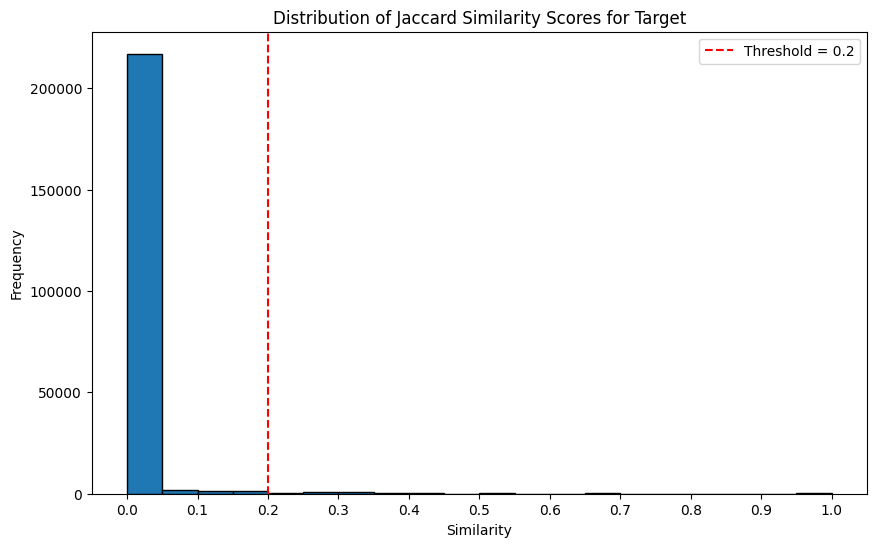

In [397]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(drug_targets_onehot_df, name_to_id=None, compute_sim='jaccard', threshold_similarity=0.2, title='Distribution of Jaccard Similarity Scores for Target', type='drug')

##### Drug Target Edges

In [398]:
drug_target_pairs_id = edge_name_to_id(name_pairs, DB_TO_ID_DICT)

In [399]:
drug_target_pairs_id_edge_index = torch.tensor(drug_target_pairs_id).T
drug_target_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', drug_target_pairs_id_edge_index.shape)
print('edge_index', drug_target_pairs_id_edge_index[:5])
print('edge_attributes', drug_target_pairs_id_edge_attr.shape)
print('edge_attributes', drug_target_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 3363])
edge_index tensor([[  0,   0,   0,  ..., 948, 962, 963],
        [  2, 360, 377,  ..., 987, 996, 991]])
edge_attributes torch.Size([3363])
edge_attributes tensor([1.0000, 0.3333, 0.3333, 0.5000, 0.6667], dtype=torch.float64)


#### Drug SE Interaction Profile

In [400]:
idse_association_df.head(1)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name,drug_name,drug_smiles
0,DB04441,2-Fluoroadenosine,C0000737,Abdominal pain,2-Fluoroadenosine,[H][C@]1(CO)O[C@@]([H])(N2C=NC3=C(N)N=C(F)N=C2...


In [401]:
all_se_id

array(['C0000727', 'C0000729', 'C0000731', ..., 'C3665818', 'C3665888',
       'C3665900'], dtype=object)

In [402]:
def all_of_k_encoding_unk(x, allowable_set):
    enc = np.zeros(len(allowable_set))
    for idx, side_eff_id in enumerate(allowable_set):
        if side_eff_id in x:
            enc[idx] = 1
    return enc

In [403]:
drug_se_list_df = idse_association_df.groupby('drugbank_id')['umls_cui_from_meddra'].apply(list)
drug_se_list_df.head(1)

drugbank_id
DB00014    [C0000737, C0702166, C0948089, C0559546, C0233...
Name: umls_cui_from_meddra, dtype: object

In [404]:
# generate encode side effect interaction profile
se_encoded_drug_id = [all_of_k_encoding_unk(drug_se_list_df.get(id), all_se_id) for id in all_drug_id]

In [405]:
drug_se_encoded_df = pd.DataFrame(se_encoded_drug_id, columns=all_se_id, index=all_drug_id)
# bool df
drug_se_encoded_df = drug_se_encoded_df.astype(bool)
drug_se_encoded_df.head(1)

,C0000727,C0000729,C0000731,C0000735,C0000737,C0000768,C0000772,C0000786,C0000814,C0000832,C0000833,C0000889,C0000924,C0000932,C0001122,C0001125,C0001126,C0001127,C0001175,C0001198,C0001206,C0001231,C0001339,C0001349,C0001361,C0001364,C0001396,C0001403,C0001416,C0001418,C0001430,C0001486,C0001511,C0001546,C0001621,C0001622,C0001623,C0001707,C0001807,C0001816,C0001818,C0001824,C0001849,C0001883,C0001916,C0001925,C0001957,C0001969,C0001973,C0002063,C0002064,C0002103,C0002170,C0002390,C0002395,C0002418,C0002447,C0002453,C0002622,C0002624,C0002726,C0002792,C0002871,C0002874,C0002878,C0002880,C0002884,C0002886,C0002888,C0002891,C0002893,C0002894,C0002895,C0002896,C0002902,C0002928,C0002940,C0002957,C0002962,C0002963,C0002965,C0002994,C0003028,C0003044,C0003079,C0003119,C0003123,C0003126,C0003128,C0003130,C0003175,C0003431,C0003460,C0003462,C0003466,C0003467,C0003469,C0003486,C0003492,C0003493,C0003504,C0003507,C0003537,C0003564,C0003578,C0003615,C0003621,C0003635,C0003708,C0003742,C0003811,C0003813,C0003834,C0003838,C0003850,C0003855,C0003860,C0003862,C0003864,C0003868,C0003869,C0003873,C0003892,C0003950,C0003962,C0004030,C0004044,C0004063,C0004093,C0004095,C0004096,C0004114,C0004134,C0004144,C0004153,C0004158,C0004161,C0004238,C0004239,C0004245,C0004331,C0004364,C0004377,C0004509,C0004601,C0004604,C0004610,C0004623,C0004626,C0004659,C0004690,C0004691,C0004763,C0004767,C0004812,C0004930,C0004936,C0004998,C0005001,C0005398,C0005411,C0005424,C0005586,C0005681,C0005683,C0005684,C0005686,C0005694,C0005695,C0005697,C0005699,C0005716,C0005741,C0005743,C0005745,C0005747,C0005758,C0005778,C0005779,C0005818,C0005826,C0005940,C0005944,C0005959,C0005967,C0006079,C0006105,C0006107,C0006111,C0006112,C0006114,C0006118,C0006142,C0006144,C0006145,C0006147,C0006152,C0006261,C0006266,C0006267,C0006271,C0006272,C0006277,C0006285,C0006287,C0006325,C0006370,C0006384,C0006413,C0006430,C0006434,C0006435,C0006444,C0006625,C0006663,C0006705,C0006826,C0006840,C0006846,C0006848,C0006849,C0006852,C0006905,C0007078,C0007095,C0007097,C0007102,C0007103,C0007107,C0007112,C0007113,C0007114,C0007115,C0007117,C0007120,C0007131,C0007134,C0007137,C0007166,C0007177,C0007193,C0007194,C0007196,C0007222,C0007274,C0007280,C0007282,C0007286,C0007302,C0007370,C0007384,C0007398,C0007462,C0007642,C0007682,C0007758,C0007760,C0007766,C0007773,C0007780,C0007785,C0007787,C0007815,C0007820,C0007855,C0007859,C0007860,C0007863,C0007867,C0007868,C0007869,C0007873,C0007933,C0007971,C0008031,C0008033,C0008035,C0008039,C0008049,C0008149,C0008301,C0008311,C0008313,C0008325,C0008350,C0008370,C0008372,C0008449,C0008489,C0008497,C0008513,C0008526,C0008626,C0008728,C0008733,C0008909,C0008924,C0008925,C0009024,C0009062,C0009081,C0009088,C0009144,C0009193,C0009241,C0009269,C0009319,C0009324,C0009326,C0009376,C0009377,C0009421,C0009443,C0009450,C0009492,C0009595,C0009663,C0009676,C0009759,C0009760,C0009763,C0009766,C0009768,C0009782,C0009806,C0009917,C0009918,C0009938,C0009946,C0009952,C0010032,C0010034,C0010037,C0010038,C0010043,C0010054,C0010068,C0010072,C0010073,C0010093,C0010200,C0010263,C0010266,C0010278,C0010346,C0010399,C0010414,C0010417,C0010418,C0010481,C0010495,C0010520,C0010666,C0010692,C0010709,C0010823,C0010828,C0010930,C0011053,C0011057,C0011071,C0011124,C0011127,C0011168,C0011175,C0011206,C0011253,C0011269,C0011304,C0011334,C0011432,C0011551,C0011570,C0011581,C0011603,C0011606,C0011609,C0011615,C0011616,C0011630,C0011633,C0011636,C0011644,C0011649,C0011757,C0011848,C0011849,C0011854,C0011860,C0011875,C0011880,C0011881,C0011882,C0011884,C0011974,C0011991,C0012241,C0012254,C0012359,C0012569,C0012624,C0012691,C0012739,C0012746,C0012797,C0012813,C0012817,C0012833,C0013080,C0013132,C0013144,C0013146,C0013182,C0013220,C0013221,C0013238,C0013240,C0013274,C0013295,C0013298,C0013312,C0013336,C0013362,C0013363,C0013369,C0013378,C0013384,C0013390,C0013395,C0013404,C0013415,C0013418,C0013423,C0013428,C0013447,C0013456,C0013473,C0013491,C0013528,C0013537,C0013589,C0013592,C0013595,C0013604,C00

##### Similarity score using Jaccard

Number of pairs with similarity above 0.2: 65854/506521
Percentage above threshold_similarity 0.2: 0.13001237855883566
Number of drug pairs with similarity above 0.2: 65854
Sample pairs: [['DB00014', 'DB00035'], ['DB00014', 'DB00091'], ['DB00014', 'DB00104'], ['DB00014', 'DB00175'], ['DB00014', 'DB00176']]


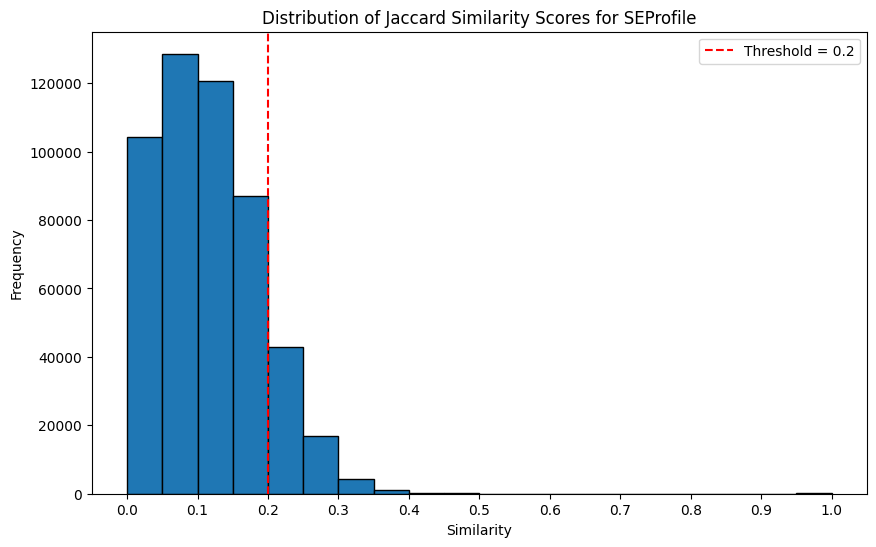

In [406]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(drug_se_encoded_df, name_to_id=None, compute_sim='jaccard', threshold_similarity=0.2, title='Distribution of Jaccard Similarity Scores for SEProfile', type='drug')

##### Drug SEProfile Edges

In [407]:
drug_sep_pairs_id = edge_name_to_id(name_pairs, DB_TO_ID_DICT)

In [408]:
drug_sep_pairs_id_edge_index = torch.tensor(drug_sep_pairs_id).T
drug_sep_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', drug_sep_pairs_id_edge_index.shape)
print('edge_index', drug_sep_pairs_id_edge_index[:, :5])
print('edge_attributes', drug_sep_pairs_id_edge_attr.shape)
print('edge_attributes', drug_sep_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 65854])
edge_index tensor([[ 0,  0,  0,  0,  0],
        [ 1,  3,  4, 14, 15]])
edge_attributes torch.Size([65854])
edge_attributes tensor([0.2492, 0.2644, 0.2770, 0.2443, 0.2878], dtype=torch.float64)


#### SE Word Feature

In [409]:
# Load pre-trained GloVe vectors
glove = vocab.GloVe(name='6B', dim=300)

In [410]:
def get_glove_emb(se_name):
    words = se_name.split()  # Split the side effect name into words
    embeddings = [glove[word] for word in words if word in glove.stoi]
    if not embeddings:
        # Handle synonyms or rare words here
        return None
    average_embedding = sum(embeddings) / len(embeddings)
    return average_embedding

In [411]:
se_name_emb = [(sid, get_glove_emb(se_uml_to_se_name_dict[sid])) for sid in all_se_id]
se_name_emb = [(sid, emb.numpy()) for sid, emb in se_name_emb if emb is not None]


se_name_emb[0][0], se_name_emb[0][1].shape

('C0000727', (300,))

In [412]:
se_name_idx, se_emb = zip(*se_name_emb)
se_name_emb_df = pd.DataFrame(se_emb, index=se_name_idx)

se_name_emb_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
C0000727,-0.174295,0.368425,-0.219301,-0.30479,0.059408,0.000191,-0.094405,-0.078763,-0.35843,-0.7018,0.051435,-0.34956,-0.6089,0.1404,-0.07169,0.279345,-0.865275,0.083197,-0.55543,-0.308545,-0.686985,0.093855,-0.484025,-0.31999,-0.339565,0.12419,0.36199,-0.32234,-0.243,0.20587,-0.461515,0.62316,-0.06452,0.22637,0.208192,-0.057695,-0.121145,-0.001455,-0.109126,0.562535,0.011015,-0.329895,0.249595,-0.447725,0.069688,0.318915,0.005885,-0.061504,-0.34817,0.22304,0.09453,0.106893,0.31482,0.0908,-0.117626,-0.635225,0.015232,0.05713,0.30952,0.44635,0.08141,-0.145115,-0.102248,-0.3281,-0.02512,-0.48193,0.256285,-0.248668,0.133155,0.272845,0.18779,0.01039,0.32841,0.0484,0.37378,-0.46481,-0.092828,-0.01317,0.06513,0.156113,0.018845,-0.00919,0.090832,-0.237774,0.036008,-0.096095,0.317002,0.194993,-0.0491,0.72256,0.07794,0.06116,-0.597045,0.304945,-0.104295,-0.014231,-0.00092,-0.11283,0.53659,-0.2945,0.215394,-0.23076,-0.370355,0.262943,-0.144386,0.233698,0.322398,-0.051155,-0.02029,0.444935,-0.66846,0.077015,0.032644,-0.109271,0.583235,-0.386455,-0.5318,-0.212411,-0.173747,-0.167437,-0.47956,-0.53185,-0.167605,0.250515,-0.02977,0.426905,-0.266993,-0.37217,0.291925,-0.32255,0.521765,-0.30259,0.039845,0.283188,-0.51994,-0.30949,-0.17128,0.237915,-0.005015,0.81128,0.258575,0.179257,-0.329555,-0.00972,-0.265713,0.25172,-0.053738,-0.355967,-0.1306,0.458945,-0.077017,0.146687,0.587695,0.32489,0.6301,0.214845,0.120788,0.461665,0.52502,0.195069,-0.107883,-0.135089,0.140955,-0.140215,0.12862,0.423045,-0.206979,-0.380012,0.333195,-0.211142,0.104418,0.58037,0.26692,-0.316385,-0.374815,-0.353965,0.041188,-0.019525,0.223935,-0.357674,-0.530875,-0.49875,-0.30517,0.072513,-0.335889,-0.107211,0.32894,-0.29337,-0.17611,-0.069196,0.255705,0.539925,-0.147408,0.11357,-0.26604,0.73045,-0.04901,-0.457705,0.025085,0.79498,-0.066525,-0.074285,-0.39685,-0.095236,-0.19288,0.474585,-0.34283,-0.094152,-0.204028,0.55726,0.296166,-0.80268,0.25931,-0.39409,0.738355,-0.279725,0.562215,-0.64176,0.40911,-0.179244,-0.224629,-0.058463,0.033245,0.269978,-0.096945,0.295585,-0.437295,-0.452645,-0.25112,-0.29423,0.295565,0.138151,0.40113,-0.381405,-0.774465,-0.08842,0.258145,0.005675,-0.151222,-0.25508,0.120801,-0.50557,0.147948,0.35552,-0.35238,-0.08168,0.43456,0.044005,0.06955,-0.131353,-0.014602,0.408215,0.216894,-0.380295,-0.083802,0.256015,-0.251705,0.08088,0.091899,0.269545,-0.20604,-0.06333,0.079099,-0.321945,-0.26402,0.137041,-0.079905,0.017877,-0.42931,0.290359,-0.038365,0.270635,0.023277,-0.06418,0.024075,-0.111796,-0.29371,0.02886,-0.182415,0.2524,0.099026,-0.07213,0.39255,0.368195,-0.282905,0.246965,-0.61052,0.009498,0.0843,0.035493,-0.049875,-0.049366,0.315115,-0.26806,0.12162,0.10134,-0.040316,-0.22531,0.173365,-0.66501


##### Compute Cosine Similarity

Number of pairs with similarity above 0.5: 299170/12900660
Percentage above threshold_similarity 0.5: 0.023190286388448344
Number of SEEffect pairs with similarity above 0.5: 299170
Sample pairs: [['C0000727', 'C0000729'], ['C0000727', 'C0000731'], ['C0000727', 'C0000737'], ['C0000727', 'C0001127'], ['C0000727', 'C0001339']]


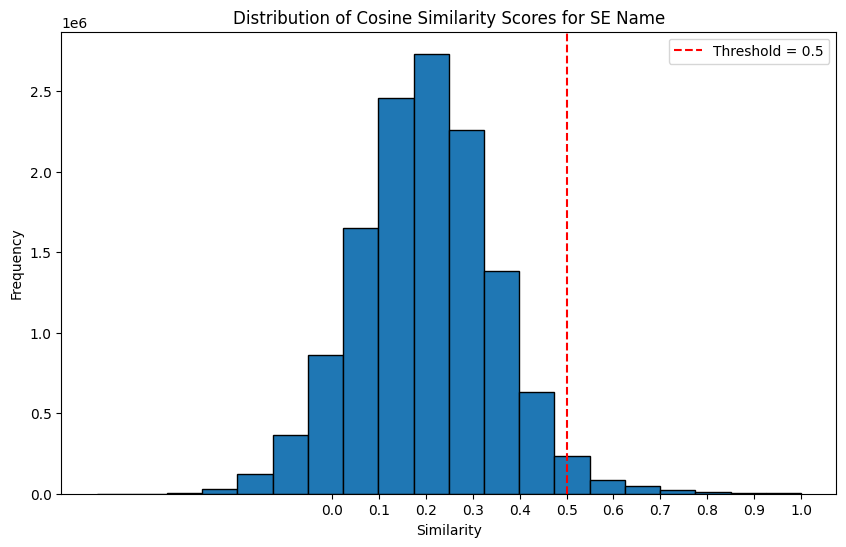

In [413]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(se_name_emb_df, name_to_id=None, compute_sim='cosine', threshold_similarity=0.5, title='Distribution of Cosine Similarity Scores for SE Name', type='SEEffect')

##### SE Word Edges

In [414]:
se_name_emb_pairs_id = edge_name_to_id(name_pairs, MEDRAID_TO_ID_DICT)

In [415]:
se_name_emb_pairs_id_edge_index = torch.tensor(se_name_emb_pairs_id).T
se_name_emb_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', se_name_emb_pairs_id_edge_index.shape)
print('edge_index', se_name_emb_pairs_id_edge_index[:, :5])
print('edge_attributes', se_name_emb_pairs_id_edge_attr.shape)
print('edge_attributes', se_name_emb_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 299170])
edge_index tensor([[ 0,  0,  0,  0,  0],
        [ 1,  2,  4, 17, 22]])
edge_attributes torch.Size([299170])
edge_attributes tensor([0.5596, 0.5203, 0.6397, 0.5022, 0.7177])


#### SE Drug Interaction Profile

In [416]:
se_drug_encoded_df = drug_se_encoded_df.T

se_drug_encoded_df.head(1)

,DB00014,DB00035,DB00050,DB00091,DB00104,DB00122,DB00125,DB00130,DB00136,DB00145,DB00152,DB00153,DB00159,DB00165,DB00175,DB00176,DB00177,DB00178,DB00180,DB00181,DB00182,DB00184,DB00185,DB00186,DB00187,DB00188,DB00190,DB00191,DB00193,DB00194,DB00195,DB00196,DB00197,DB00198,DB00199,DB00200,DB00201,DB00202,DB00203,DB00204,DB00205,DB00206,DB00207,DB00208,DB00209,DB00210,DB00211,DB00213,DB00214,DB00215,DB00216,DB00218,DB00220,DB00222,DB00223,DB00224,DB00225,DB00227,DB00228,DB00230,DB00231,DB00232,DB00234,DB00235,DB00237,DB00238,DB00239,DB00240,DB00242,DB00243,DB00244,DB00245,DB00246,DB00247,DB00248,DB00249,DB00250,DB00251,DB00252,DB00253,DB00257,DB00259,DB00260,DB00261,DB00262,DB00264,DB00265,DB00268,DB00270,DB00271,DB00273,DB00275,DB00276,DB00277,DB00278,DB00279,DB00280,DB00281,DB00282,DB00283,DB00284,DB00285,DB00287,DB00288,DB00289,DB00290,DB00291,DB00292,DB00293,DB00294,DB00295,DB00296,DB00297,DB00299,DB00300,DB00301,DB00303,DB00304,DB00305,DB00307,DB00308,DB00310,DB00312,DB00314,DB00315,DB00316,DB00317,DB00318,DB00319,DB00320,DB00321,DB00322,DB00323,DB00324,DB00327,DB00328,DB00330,DB00331,DB00333,DB00335,DB00337,DB00338,DB00339,DB00341,DB00343,DB00344,DB00346,DB00347,DB00348,DB00349,DB00352,DB00353,DB00355,DB00356,DB00357,DB00358,DB00359,DB00360,DB00361,DB00362,DB00364,DB00366,DB00367,DB00368,DB00369,DB00370,DB00371,DB00373,DB00374,DB00376,DB00377,DB00379,DB00380,DB00381,DB00384,DB00385,DB00388,DB00389,DB00390,DB00393,DB00394,DB00395,DB00396,DB00397,DB00398,DB00399,DB00400,DB00401,DB00402,DB00404,DB00408,DB00410,DB00411,DB00412,DB00413,DB00415,DB00418,DB00419,DB00421,DB00422,DB00423,DB00424,DB00425,DB00426,DB00428,DB00431,DB00432,DB00433,DB00434,DB00436,DB00437,DB00438,DB00439,DB00440,DB00441,DB00442,DB00443,DB00444,DB00445,DB00446,DB00448,DB00449,DB00450,DB00451,DB00452,DB00454,DB00455,DB00457,DB00458,DB00459,DB00460,DB00461,DB00465,DB00468,DB00469,DB00470,DB00471,DB00472,DB00474,DB00476,DB00477,DB00478,DB00479,DB00480,DB00481,DB00482,DB00484,DB00485,DB00486,DB00488,DB00489,DB00490,DB00491,DB00492,DB00493,DB00494,DB00495,DB00496,DB00497,DB00499,DB00500,DB00501,DB00502,DB00503,DB00507,DB00509,DB00512,DB00514,DB00515,DB00518,DB00519,DB00520,DB00521,DB00523,DB00524,DB00528,DB00529,DB00530,DB00531,DB00532,DB00533,DB00534,DB00535,DB00536,DB00537,DB00538,DB00539,DB00540,DB00541,DB00542,DB00543,DB00544,DB00545,DB00547,DB00549,DB00550,DB00552,DB00553,DB00555,DB00556,DB00557,DB00558,DB00559,DB00561,DB00563,DB00564,DB00566,DB00567,DB00570,DB00571,DB00572,DB00573,DB00575,DB00577,DB00578,DB00580,DB00581,DB00582,DB00583,DB00584,DB00585,DB00586,DB00589,DB00590,DB00593,DB00594,DB00597,DB00598,DB00600,DB00601,DB00602,DB00605,DB00607,DB00608,DB00609,DB00611,DB00612,DB00615,DB00619,DB00620,DB00621,DB00622,DB00623,DB00624,DB00625,DB00626,DB00627,DB00628,DB00629,DB00630,DB00631,DB00632,DB00633,DB00634,DB00635,DB00639,DB00640,DB00641,DB00642,DB00643,DB00644,DB00647,DB00648,DB00649,DB00650,DB00651,DB00652,DB00654,DB00655,DB00656,DB00657,DB00658,DB00659,DB00660,DB00661,DB00662,DB00665,DB00666,DB00668,DB00669,DB00671,DB00672,DB00673,DB00674,DB00675,DB00678,DB00679,DB00683,DB00684,DB00685,DB00687,DB00690,DB00692,DB00693,DB00694,DB00695,DB00696,DB00697,DB00698,DB00700,DB00701,DB00703,DB00704,DB00705,DB00706,DB00708,DB00709,DB00710,DB00712,DB00713,DB00714,DB00715,DB00716,DB00717,DB00720,DB00721,DB00722,DB00724,DB00726,DB00727,DB00728,DB00730,DB00731,DB00732,DB00733,DB00734,DB00735,DB00736,DB00737,DB00738,DB00740,DB00741,DB00742,DB00744,DB00745,DB00746,DB00747,DB00748,DB00749,DB00750,DB00751,DB00752,DB00753,DB00754,DB00755,DB00756,DB00757,DB00758,DB00760,DB00762,DB00763,DB00764,DB00765,DB00766,DB00768,DB00770,DB00772,DB00773,DB00774,DB00775,DB00776,DB00778,DB00780,DB00782,DB00783,DB00787,DB00788,DB00790,DB00794,DB00796,DB00798,DB00799,DB00800,DB00802,DB00804,DB00806,DB00807,DB00808,DB00809,DB00811,DB00813,DB00814,DB00816,DB00818,DB00819,DB00820,DB00822,DB00826,DB00827,DB00828,DB00829,DB00831,DB00833,DB00834,DB00836,DB00838,DB00839,DB00841,DB00842,DB00843

##### Similarity using Jaccard Score

Number of pairs with similarity above 0.2: 101114/15604491
Percentage above threshold_similarity 0.2: 0.006479801231581344
Number of SEEffect pairs with similarity above 0.2: 101114
Sample pairs: [['C0000727', 'C0016034'], ['C0000727', 'C0020255'], ['C0000731', 'C0000737'], ['C0000731', 'C0002170'], ['C0000731', 'C0002622']]


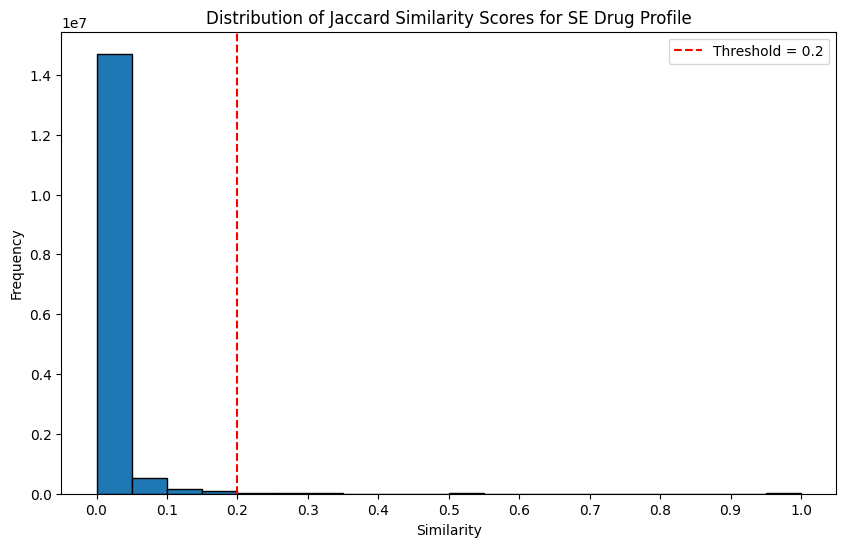

In [417]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(se_drug_encoded_df, name_to_id=None, compute_sim='jaccard', threshold_similarity=0.2, title='Distribution of Jaccard Similarity Scores for SE Drug Profile', type='SEEffect')

##### SE DIPA edges

In [418]:
se_drug_encoded_pairs_id = edge_name_to_id(name_pairs, MEDRAID_TO_ID_DICT)

In [419]:
se_drug_encoded_pairs_id_edge_index = torch.tensor(se_drug_encoded_pairs_id).T
se_drug_encoded_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', se_drug_encoded_pairs_id_edge_index.shape)
print('edge_index', se_drug_encoded_pairs_id_edge_index[:, :5])
print('edge_attributes', se_drug_encoded_pairs_id_edge_attr.shape)
print('edge_attributes', se_drug_encoded_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 101114])
edge_index tensor([[  0,   0,   2,   2,   2],
        [544, 717,   4,  52,  58]])
edge_attributes torch.Size([101114])
edge_attributes tensor([0.2143, 0.2222, 0.3250, 0.2713, 0.2570], dtype=torch.float64)


#### SE ATC

In [420]:
atc_sim_df = pd.read_csv("../prep_data/adrecs/similarity_model.csv")
atc_sim_df.head(1)

,acute abdomen,abdominal distension,abdominal neoplasm,abdominal pain,congenital anomaly,multiple congenital abnormalities,abortion spontaneous,abortion missed,abscess,acanthosis nigricans,accident,acidosis,lactic acidosis,renal tubular acidosis,respiratory acidosis,acquired immunodeficiency syndrome,acrodynia,pancreatitis acute,acute phase reaction,acute tonsillitis,adams-stokes syndrome,addison's disease,adenocarcinoma,adenoma benign,adenovirus infection,adhesion,adjustment disorder,adrenal disorder,hyperadrenocorticism,adrenal insufficiency,aerophagia,aggression,agoraphobia,agranulocytosis,albinism,albuminuria,delirium tremens,alcoholism,alkalosis,respiratory alkalosis,alopecia,alveolitis allergic,dementia alzheimer's type,amblyopia,amenorrhoea,amnesia,retrograde amnesia,amyloidosis,anaphylactic shock,anaemia,aplastic anaemia,haemolytic anaemia,autoimmune haemolytic anaemia,hypochromic anaemia,anaemia macrocytic,anaemia megaloblastic,anaemia neonatal,sickle cell anaemia,sideroblastic anaemia,anencephaly,spinal anaesthesia,aneurysm,anger,angina pectoris,prinzmetal angina,angina unstable,angioedema,anhidrosis,animal bite,pupils unequal,anophthalmos,anorexia,anosmia,anoxia,antisocial personality disorder,anuria,anal atresia,anxiety,anxiety disorder,aortic aneurysm,coarctation of the aorta,aortic disorder,aortic valve incompetence,aortic valve stenosis,aphasia,aphonia,apnoea,appendicitis,appetite disorder,apraxia,arachnoiditis,arrhythmia,sinus arrhythmia,arterial insufficiency,arterial occlusive disease,arteriosclerosis,arteriovenous fistula,arteritis,arthralgia,arthritis,gouty arthritis,arthritis infective,rheumatoid arthritis,neuropathic arthropathy,ascariasis,ascites,aspergillosis,asphyxia,asthenia,asthenopia,asthma,astrocytoma,ataxia,atelectasis,athetosis,atrial fibrillation,atrial flutter,atrioventricular block,atrioventricular dissociation,autoimmune disorder,automatism,azoospermia,back injury,back pain,bacteraemia,bacterial infection,pneumonia bacterial,bacteriuria,balanitis,balanoposthitis,barrett's oesophagus,mental disorder,benign neoplasm of skin,biliary tract disorder,bipolar disorder,blackwater fever,calculus bladder,bladder cancer,bladder disorder,bladder neck obstruction,bladder neoplasm,neurogenic bladder,blast cell crisis,blastomycosis,blepharitis,eyelid ptosis,blepharospasm,blister,coagulopathy,platelet disorder,blood pressure abnormal,bone disorder,marrow hyperplasia,bone neoplasm,bowen's disease,brain abscess,concussion,metabolic encephalopathy,brain neoplasm,breast cancer,breast cyst,breast disorder,breast feeding,breast swelling,bronchospasm,bronchiectasis,bronchiolitis,obliterative bronchiolitis,bronchitis,bronchopneumonia,bronchopulmonary dysplasia,bruxism,bundle branch block,burkitt's lymphoma,burning mouth syndrome,bursitis,cachexia,calcinosis,calcium metabolism disorder,neoplasm malignant,skin candida,mucocutaneous candidiasis,oral candidiasis,capillary fragility,carbuncle,carcinoid tumour,colon cancer,laryngeal cancer,rectal cancer,skin cancer,thyroid cancer,basal cell carcinoma,bronchioloalveolar carcinoma,non-small cell lung cancer,renal cell carcinoma,squamous cell carcinoma,cardiac output decreased,cardiac tamponade,congestive cardiomyopathy,hypertrophic cardiomyopathy,restrictive cardiomyopathy,cardiovascular disorder,carotid artery thrombosis,carotid bruit,carotid artery stenosis,carpal tunnel syndrome,chondropathy,catalepsy,cataplexy,catatonia,cellulitis,cerebellar ataxia,cerebellar syndrome,intracranial aneurysm,cerebral arteritis,cerebral artery embolism,cerebral infarction,transient ischaemic attack,cerebrovascular disorder,cervical polyp,neck pain,cervicitis,occipital neuralgia,cervix disorder,cervical dysplasia,uterine cervical erosion,cervix neoplasm,chalazion,cheilitis,chest pain,pleuritic pain,cheyne-stokes respiration,varicella,choking,cholangitis,cholangitis sclerosing,cholecystitis,cholelithiasis,cholestasis,chondrodystrophy,chorea,choriocarcinoma,chorioretinitis,choroiditis,cytogen

In [421]:
valid_indices = [name for idx, name in enumerate(atc_sim_df.index) if name in se_name_to_se_uml_dict]
    

In [422]:
atc_sim_df_filtered = atc_sim_df.loc[valid_indices, valid_indices]
atc_sim_df_filtered.head(1)

,acute abdomen,abdominal distension,abdominal neoplasm,abdominal pain,congenital anomaly,multiple congenital abnormalities,abortion spontaneous,abortion missed,abscess,acanthosis nigricans,accident,acidosis,lactic acidosis,renal tubular acidosis,respiratory acidosis,acquired immunodeficiency syndrome,acrodynia,pancreatitis acute,acute phase reaction,acute tonsillitis,adams-stokes syndrome,addison's disease,adenocarcinoma,adenoma benign,adenovirus infection,adhesion,adjustment disorder,adrenal disorder,hyperadrenocorticism,adrenal insufficiency,aerophagia,aggression,agoraphobia,agranulocytosis,albinism,albuminuria,delirium tremens,alcoholism,alkalosis,respiratory alkalosis,alopecia,alveolitis allergic,dementia alzheimer's type,amblyopia,amenorrhoea,amnesia,retrograde amnesia,amyloidosis,anaphylactic shock,anaemia,aplastic anaemia,haemolytic anaemia,autoimmune haemolytic anaemia,hypochromic anaemia,anaemia macrocytic,anaemia megaloblastic,anaemia neonatal,sickle cell anaemia,sideroblastic anaemia,anencephaly,spinal anaesthesia,aneurysm,anger,angina pectoris,prinzmetal angina,angina unstable,angioedema,anhidrosis,animal bite,pupils unequal,anophthalmos,anorexia,anosmia,anoxia,antisocial personality disorder,anuria,anal atresia,anxiety,anxiety disorder,aortic aneurysm,coarctation of the aorta,aortic disorder,aortic valve incompetence,aortic valve stenosis,aphasia,aphonia,apnoea,appendicitis,appetite disorder,apraxia,arachnoiditis,arrhythmia,sinus arrhythmia,arterial insufficiency,arterial occlusive disease,arteriosclerosis,arteriovenous fistula,arteritis,arthralgia,arthritis,gouty arthritis,arthritis infective,rheumatoid arthritis,neuropathic arthropathy,ascariasis,ascites,aspergillosis,asphyxia,asthenia,asthenopia,asthma,astrocytoma,ataxia,atelectasis,athetosis,atrial fibrillation,atrial flutter,atrioventricular block,atrioventricular dissociation,autoimmune disorder,automatism,azoospermia,back injury,back pain,bacteraemia,bacterial infection,pneumonia bacterial,bacteriuria,balanitis,balanoposthitis,barrett's oesophagus,mental disorder,benign neoplasm of skin,biliary tract disorder,bipolar disorder,blackwater fever,calculus bladder,bladder cancer,bladder disorder,bladder neck obstruction,bladder neoplasm,neurogenic bladder,blast cell crisis,blastomycosis,blepharitis,eyelid ptosis,blepharospasm,blister,coagulopathy,platelet disorder,blood pressure abnormal,bone disorder,marrow hyperplasia,bone neoplasm,bowen's disease,brain abscess,concussion,metabolic encephalopathy,brain neoplasm,breast cancer,breast cyst,breast disorder,breast feeding,breast swelling,bronchospasm,bronchiectasis,bronchiolitis,obliterative bronchiolitis,bronchitis,bronchopneumonia,bronchopulmonary dysplasia,bruxism,bundle branch block,burkitt's lymphoma,burning mouth syndrome,bursitis,cachexia,calcinosis,calcium metabolism disorder,neoplasm malignant,skin candida,mucocutaneous candidiasis,oral candidiasis,capillary fragility,carbuncle,carcinoid tumour,colon cancer,laryngeal cancer,rectal cancer,skin cancer,thyroid cancer,basal cell carcinoma,bronchioloalveolar carcinoma,non-small cell lung cancer,renal cell carcinoma,squamous cell carcinoma,cardiac output decreased,cardiac tamponade,congestive cardiomyopathy,hypertrophic cardiomyopathy,restrictive cardiomyopathy,cardiovascular disorder,carotid artery thrombosis,carotid bruit,carotid artery stenosis,carpal tunnel syndrome,chondropathy,catalepsy,cataplexy,catatonia,cellulitis,cerebellar ataxia,cerebellar syndrome,intracranial aneurysm,cerebral arteritis,cerebral artery embolism,cerebral infarction,transient ischaemic attack,cerebrovascular disorder,cervical polyp,neck pain,cervicitis,occipital neuralgia,cervix disorder,cervical dysplasia,uterine cervical erosion,cervix neoplasm,chalazion,cheilitis,chest pain,pleuritic pain,cheyne-stokes respiration,varicella,choking,cholangitis,cholangitis sclerosing,cholecystitis,cholelithiasis,cholestasis,chondrodystrophy,chorea,choriocarcinoma,chorioretinitis,choroiditis,cytogen

Number of pairs with similarity above 0.2: 26140/6335020
Percentage above threshold_similarity 0.2: 0.004126269530325082
Number of SEEffect pairs with similarity above 0.2: 26140
Sample pairs: [['acute abdomen', 'bruxism'], ['acute abdomen', 'dysphagia'], ['acute abdomen', 'faecal incontinence'], ['acute abdomen', 'breath odour'], ['acute abdomen', 'hiccups']]


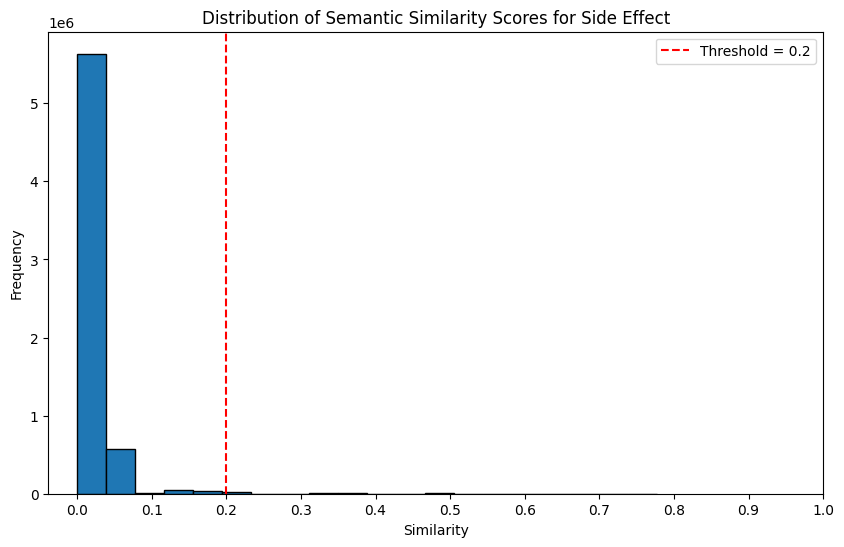

In [423]:
plt, name_pair_sim_df, name_pairs, name_pairs_attr = analyse_similarity_and_get_edge(atc_sim_df_filtered, se_name_to_se_uml_dict, compute_sim=None, threshold_similarity=0.2, title='Distribution of Semantic Similarity Scores for Side Effect', type='SEEffect')

##### SE Semnatic edges

In [424]:
se_atc_pairs_id = edge_name_to_id(name_pairs, MEDRAID_TO_ID_DICT)

In [425]:
se_atc_pairs_id_edge_index = torch.tensor(se_atc_pairs_id).T
se_atc_pairs_id_edge_attr = torch.tensor(name_pairs_attr) #.unsqueeze(1) #, dtype=torch.float64)

print('edge_index', se_atc_pairs_id_edge_index.shape)
print('edge_index', se_atc_pairs_id_edge_index[:, :5])
print('edge_attributes', se_atc_pairs_id_edge_attr.shape)
print('edge_attributes', se_atc_pairs_id_edge_attr[:5])

edge_index torch.Size([2, 26140])
edge_index tensor([[  0,   0,   0,   0,   0],
        [205, 363, 530, 620, 701]])
edge_attributes torch.Size([26140])
edge_attributes tensor([0.3784, 0.4667, 0.3784, 0.4667, 0.3784], dtype=torch.float64)


### Instantiate Pyg HetroData

In [430]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(len(all_drug_id))
data['side_effect'].node_id = torch.arange(len(all_se_id))

# Add node features
# data['drug'].x = drug_node_features

# Add edges
data['drug', 'known', 'side_effect'].edge_index = edge_index

# add dummpy tensor of 1s for edge_attr for know drug-se edges
# data['drug', 'known', 'side_effect'].edge_attr = torch.ones(edge_index.shape[1])

# add drug-drug edges
data['drug', 'struct', 'drug'].edge_index = drug_struct_pairs_id_edge_index
data['drug', 'word', 'drug'].edge_index = drug_word_pairs_id_edge_index
data['drug', 'target', 'drug'].edge_index = drug_target_pairs_id_edge_index
data['drug', 'se_encoded', 'drug'].edge_index = drug_sep_pairs_id_edge_index

# add se-se edges
data['side_effect', 'name', 'side_effect'].edge_index = se_name_emb_pairs_id_edge_index
data['side_effect', 'dg_encoded', 'side_effect'].edge_index = se_drug_encoded_pairs_id_edge_index
data['side_effect', 'atc', 'side_effect'].edge_index = se_atc_pairs_id_edge_index

# add drug-drug edges attributes
data['drug', 'struct', 'drug'].edge_attr = drug_struct_pairs_id_edge_attr.float()
data['drug', 'word', 'drug'].edge_attr = drug_word_pairs_id_edge_attr.float()
data['drug', 'target', 'drug'].edge_attr = drug_target_pairs_id_edge_attr.float()
data['drug', 'se_encoded', 'drug'].edge_attr = drug_sep_pairs_id_edge_attr.float()

# add se-se edges attributes
data['side_effect', 'name', 'side_effect'].edge_attr = se_name_emb_pairs_id_edge_attr.float()
data['side_effect', 'dg_encoded', 'side_effect'].edge_attr = se_drug_encoded_pairs_id_edge_attr.float()
data['side_effect', 'atc', 'side_effect'].edge_attr = se_atc_pairs_id_edge_attr.float()

# add final drug-drug edges
# data['drug', 'to', 'drug'].edge_index = final_drug_edges
# data['drug', 'to', 'drug'].edge_attr = torch.tensor(np.array(final_drug_edges_attr))

# # add final se-se edges
# data['side_effect', 'to', 'side_effect'].edge_index = final_se_edges
# data['side_effect', 'to', 'side_effect'].edge_attr = torch.tensor(np.array(final_se_edges_attr))

print(data)

HeteroData(
  drug={ node_id=[1007] },
  side_effect={ node_id=[5587] },
  (drug, known, side_effect)={ edge_index=[2, 132063] },
  (drug, struct, drug)={
    edge_index=[2, 15844],
    edge_attr=[15844]
  },
  (drug, word, drug)={
    edge_index=[2, 83865],
    edge_attr=[83865]
  },
  (drug, target, drug)={
    edge_index=[2, 3363],
    edge_attr=[3363]
  },
  (drug, se_encoded, drug)={
    edge_index=[2, 65854],
    edge_attr=[65854]
  },
  (side_effect, name, side_effect)={
    edge_index=[2, 299170],
    edge_attr=[299170]
  },
  (side_effect, dg_encoded, side_effect)={
    edge_index=[2, 101114],
    edge_attr=[101114]
  },
  (side_effect, atc, side_effect)={
    edge_index=[2, 26140],
    edge_attr=[26140]
  }
)


In [431]:
# data_dict = data.to_dict()
fnm = '../prep_data/hetero_graph/hetero_data_dict.pt'
os.makedirs(os.path.dirname(fnm), exist_ok=True)


In [432]:
torch.save(data, fnm)

In [429]:
# loaded_data = torch.load(fnm)